# Power System Analysis 2025/26 @ IST Work assessment

When running the code, always run all cells!

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Question 1

First, we read the excel file with the network data and create a dictionary of datasets, one for each sheet. As we can see from the output of dfs.keys(), we now have five datasets: 'Nodes', 'Transformers', 'Generators', 'Lines' and 'Loads'.

In [3]:
path = "network_data.xlsx"
xls = pd.ExcelFile(path)

# Dictionary to hold DataFrames
dfs = {}

for sheet in xls.sheet_names:
    dfs[sheet] = pd.read_excel(xls, sheet_name=sheet)

# Display the keys to verify loading
dfs.keys()

dict_keys(['Nodes', 'Transformers', 'Generators', 'Lines', 'Loads'])

The next step is to properly define the base system, as well a the Fortescue matrix to use in later calculations. The base currents will be calculated based on the "Nodes" dataset, which presents the base voltages for each node of the system. Additionally, the base power is set to a fixed 100MVA.

Apart from this, the Resistances and Reactances were combined into a single Impedance collumn in all the datasets for easier handling - and converted from Ohm to per-unit when necessary.

Frequency, maximum fault resistance and maximum fault time are also declared here, since these are constants.

In [4]:
# Define base system:

f = 50 # Hz
Sb=100e6 # W (100 MVA)

# Compute base current
dfs["Nodes"]["Base Current [pu]"] = Sb/(math.sqrt(3)*dfs["Nodes"]["Base Voltage [V]"]) # A

# Transformation matrix
a = np.exp(2j * np.pi / 3)
A = np.array([[1, 1, 1],
              [1, a**2, a],
              [1, a, a**2]])

Z_base = (dfs["Nodes"]["Base Voltage [V]"]**2)/Sb # Ohm

# Maximum fault parameters
tf_max = 2 # seconds
Zf_max_ohm = 40 # Ohm
Zf_max_pu = Zf_max_ohm/Z_base # pu

# Compute the network impedances in pu

# Convert to the correct base 
dfs["Transformers"]["Z [pu]"] = (
    (dfs["Transformers"]["R [pu]"] + 1j * dfs["Transformers"]["X [pu]"])
    * (Sb / (dfs["Transformers"]["Power [MVA]"] * 1e6))
)

dfs["Generators"]["Z [pu]"] = (
    (dfs["Generators"]["R [pu]"] + 1j * dfs["Generators"]["X [pu]"])
    * (Sb / (dfs["Generators"]["Power [MVA]"] * 1e6))
)

# Joins lines resistance and reactance into a complex impedance for easier handling

dfs["Lines"]["Z1 [ohm]"] = dfs["Lines"]["R1 [ohm]"] + dfs["Lines"]["X1 [ohm]"]*1j
dfs["Lines"]["Z0 [ohm]"] = dfs["Lines"]["R0 [ohm]"] + dfs["Lines"]["X0 [ohm]"]*1j

dfs["Lines"]["Z1 [pu]"] = dfs["Lines"]["Z1 [ohm]"]/(dfs["Lines"]["Voltage Level [V]"]**2/Sb)
dfs["Lines"]["Z0 [pu]"] = dfs["Lines"]["Z0 [ohm]"]/(dfs["Lines"]["Voltage Level [V]"]**2/Sb)

dfs["Nodes"]

,Node ID Number,Base Voltage [V],Base Current [pu]
0,1,150000,384.900179
1,2,150000,384.900179
2,3,150000,384.900179
3,4,150000,384.900179
4,5,150000,384.900179
5,6,150000,384.900179
6,7,150000,384.900179
7,8,150000,384.900179
8,9,150000,384.900179
9,10,10000,5773.502692


We can now construct the primitive **Impedance** and **Admittance** matrices.

Since all transformers in this system use **Ynd windings**, the star side provides a path for zero-sequence currents to flow to ground. Therefore, each transformer must be represented in the primitive **zero-sequence** matrices: they contribute impedance to the zero-sequence network.

Conversely, the delta side of the transformer blocks zero-sequence current, preventing current from returning through the generator windings. As a result, the generators are not included in the zero-sequence network.

Finally, no loads are modeled in this analysis, as load currents are generally negligible when performing short-circuit studies at the transmission/grid level.


In [5]:
# Primitive Impedance matrices
# Created by placing the impedances of each element in the diagonal of a matrix, ordered lines - transformers - generators

Zprim1 = np.diag(
    dfs["Lines"]["Z1 [pu]"].tolist()
    + dfs["Transformers"]["Z [pu]"].tolist()
    + dfs["Generators"]["Z [pu]"].tolist()
)

# The zero-sequence primitive impedance matrix does not include generators, since they are not modeled in zero-sequence

Zprim0 = np.diag(
    dfs["Lines"]["Z0 [pu]"].tolist()
    + dfs["Transformers"]["Z [pu]"].tolist()
)

# Primitive admittance matrices
# Created by inverting the primitive impedance matrices, since [Y] = [Z]^-1

Yprim1 = np.diag(1 / np.diag(Zprim1))
Yprim0 = np.diag(1 / np.diag(Zprim0))

Zprim1display = pd.DataFrame(Zprim1).round(3)
Zprim0display = pd.DataFrame(Zprim0).round(3)
Yprim1display = pd.DataFrame(Yprim1).round(3)
Yprim0display = pd.DataFrame(Yprim0).round(3)

def print_diagonal(df, name="Matrix"):
    diag = np.diag(df)  # Extract diagonal elements
    diag_str = " | ".join(f"{val:.3f}" for val in diag)
    indexes = " | ".join(str(i) for i in range(len(diag)))
    print(f"{name} diagonal elements:")
    print(f"Index: {indexes}")
    print(f"Value: {diag_str}\n")

# Display diagonals
print_diagonal(Zprim1display, "Zprim1")
print_diagonal(Zprim0display, "Zprim0")
print_diagonal(Yprim1display, "Yprim1")
print_diagonal(Yprim0display, "Yprim0")

Zprim1 diagonal elements:
Index: 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19
Value: 0.033+0.200j | 0.017+0.200j | 0.027+0.300j | 0.017+0.250j | 0.017+0.100j | 0.033+0.300j | 0.023+0.200j | 0.040+0.260j | 0.007+0.100j | 0.067+0.400j | 0.033+0.300j | 0.017+0.100j | 0.023+0.200j | 0.007+0.100j | 0.000+0.011j | 0.001+0.022j | 0.001+0.024j | 0.000+0.017j | 0.000+0.039j | 0.000+0.033j

Zprim0 diagonal elements:
Index: 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16
Value: 0.100+0.600j | 0.050+0.600j | 0.080+0.900j | 0.050+0.750j | 0.050+0.300j | 0.100+0.900j | 0.070+0.600j | 0.120+0.780j | 0.020+0.300j | 0.200+1.200j | 0.100+0.900j | 0.050+0.300j | 0.070+0.600j | 0.020+0.300j | 0.000+0.011j | 0.001+0.022j | 0.001+0.024j

Yprim1 diagonal elements:
Index: 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19
Value: 0.811-4.865j | 0.414-4.966j | 0.294-3.307j | 0.265-3.982j | 1.622-9.730j | 0.3

Next, we construct the **constraint matrices** for the zero-sequence and positive-sequence networks.  
These matrices have dimensions **12×20** (zero-sequence) and **12×17** (positive-sequence), corresponding to  the number of nodes by the number of branches in each network.

The key difference is that, for the **zero-sequence network**, generators are excluded because their delta-connected windings block zero-sequence current.

For consistency, branch currents are defined to always flow **from the lower-numbered node to the higher-numbered node**.

Since the **positive-sequence network** has the same topology as the actual physical network, we can directly use the node connection data from our datasets to build the corresponding constraint matrix.


In [6]:
# Construct the positive sequence constrain matrix C1
C1 = np.zeros((20, 12), dtype=int)  # 20 branches, 12 nodes

# Lines
for branch_idx, row in dfs["Lines"].iterrows():
    node_a = int(row["Node A"]) - 1  # 0-based indexing
    node_b = int(row["Node B"]) - 1

    C1[branch_idx, node_a] = -1
    C1[branch_idx, node_b] =  1

# Transformers
start_row = len(dfs["Lines"])  # where transformer rows begin
for trafo_idx, row in dfs["Transformers"].iterrows():
    node_h = int(row["Node H"]) - 1
    node_x = int(row["Node X"]) - 1
    row_idx = start_row + trafo_idx
    C1[row_idx, node_h] = -1
    C1[row_idx, node_x] =  1


# Generators
start_row += len(dfs["Transformers"])
for gen_idx, row in dfs["Generators"].iterrows():
    node = int(row["Connecting Nodes"]) - 1
    row_idx = start_row + gen_idx
    C1[row_idx, node] = 1


print(C1)

[[-1  1  0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  1  0  0  0  0  0  0  0  0]
 [-1  0  0  0  1  0  0  0  0  0  0  0]
 [ 0 -1  1  0  0  0  0  0  0  0  0  0]
 [ 0 -1  0  1  0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  1  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  1  0  0  0  0  0  0]
 [ 0  0 -1  0  1  0  0  0  0  0  0  0]
 [ 0  0 -1  0  0  1  0  0  0  0  0  0]
 [ 0  0  0 -1  1  0  0  0  0  0  0  0]
 [ 0  0  0  0 -1  1  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0 -1  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1  1  0  0  0]
 [-1  0  0  0  0  0  0  0  0  1  0  0]
 [ 0 -1  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0 -1  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1]]


For the **negative-sequence network**, we must account for the fact that the transformers are connected to **neutral** rather than to the delta-side node (which, in this case, is always listed in the "Node X" column).

To maintain our convention that currents flow from the lower-numbered node to the higher-numbered node, and assuming the neutral is represented as **node 0**, the "Node H" column is modified to input `+1` instead of `-1`.  

With this adjustment, the constraint matrix can be constructed in the same way as for the positive-sequence network.


In [7]:
# Construct the positive sequence constrain matrix C0
C0 = np.zeros((17, 12), dtype=int)  # 17 branches, 12 nodes

# Lines
for branch_idx, row in dfs["Lines"].iterrows():
    node_a = int(row["Node A"]) - 1  # 0-based indexing
    node_b = int(row["Node B"]) - 1

    C0[branch_idx, node_a] = -1
    C0[branch_idx, node_b] =  1

# Transformers
start_row = len(dfs["Lines"])  # where transformer rows begin
for trafo_idx, row in dfs["Transformers"].iterrows():
    node_h = int(row["Node H"]) - 1
    row_idx = start_row + trafo_idx
    C0[row_idx, node_h] = 1


print(C0)

[[-1  1  0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  1  0  0  0  0  0  0  0  0]
 [-1  0  0  0  1  0  0  0  0  0  0  0]
 [ 0 -1  1  0  0  0  0  0  0  0  0  0]
 [ 0 -1  0  1  0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  1  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  1  0  0  0  0  0  0]
 [ 0  0 -1  0  1  0  0  0  0  0  0  0]
 [ 0  0 -1  0  0  1  0  0  0  0  0  0]
 [ 0  0  0 -1  1  0  0  0  0  0  0  0]
 [ 0  0  0  0 -1  1  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0 -1  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1  1  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0]]


We can now run a simple code snippet to check if row orders match in both matrices:

In [8]:
# Check Lines
line_Z = dfs["Lines"]["Z1 [pu]"].tolist()
for i, z in enumerate(line_Z):
    assert Zprim1[i, i] == z, f"Mismatch in line {i}"

# Check Transformers
trafo_Z = dfs["Transformers"]["Z [pu]"].tolist()
for i, z in enumerate(trafo_Z):
    idx = len(line_Z) + i
    assert Zprim1[idx, idx] == z, f"Mismatch in transformer {i}"

# Check Generators
gen_Z = dfs["Generators"]["Z [pu]"].tolist()
for i, z in enumerate(gen_Z):
    idx = len(line_Z) + len(trafo_Z) + i
    assert Zprim1[idx, idx] == z, f"Mismatch in generator {i}"

print("All Zprim1 entries match C1 row order")

All Zprim1 entries match C1 row order


We now have everything needed to compute the node impedance and admittance matrices, using the following equations:
$$
[\overline{Y}] = [K]^{t}[\overline{y}][K]
$$

$$
[\overline{Z}]^{-1} = [\overline{Y}]
$$

In [9]:
# Positive Sequence Node Admittance Matrix Computation
Y1 = C1.T @ Yprim1 @ C1

# Zero Sequence Node Admittance Matrix Computation
Y0 = C0.T @ Yprim0 @ C0

# Node Impedance Matrices
Z1 = np.linalg.inv(Y1)
Z0 = np.linalg.pinv(Y0)

Z1display = pd.DataFrame(Z1).round(4)
Z0display = pd.DataFrame(Z0).round(4)
Y1display = pd.DataFrame(Y1).round(4)
Y0display = pd.DataFrame(Y0).round(4)

# Display the node impedance and admittance matrices
Z1display

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0006+0.0231j,-0.0003+0.0078j,-0.0001+0.0062j,0.0002+0.0127j,0.0001+0.0112j,-0.0001+0.0075j,-0.0002+0.0022j,0.0001+0.0112j,0.0001+0.0112j,0.0002+0.0138j,-0.0003+0.0050j,-0.0002+0.0013j
1,-0.0003+0.0078j,0.0020+0.0362j,0.0012+0.0199j,0.0007+0.0262j,0.0009+0.0227j,0.0012+0.0248j,-0.0002+0.0072j,0.0009+0.0227j,0.0009+0.0227j,-0.0002+0.0047j,0.0008+0.0231j,-0.0002+0.0042j
2,-0.0001+0.0062j,0.0012+0.0199j,0.0069+0.0711j,0.0007+0.0181j,0.0026+0.0351j,0.0051+0.0506j,0.0002+0.0258j,0.0026+0.0351j,0.0026+0.0351j,-0.0001+0.0037j,0.0005+0.0126j,-0.0003+0.0150j
3,0.0002+0.0127j,0.0007+0.0262j,0.0007+0.0181j,0.0086+0.0799j,0.0014+0.0289j,0.0008+0.0223j,-0.0003+0.0065j,0.0014+0.0289j,0.0014+0.0289j,0.0001+0.0076j,0.0002+0.0166j,-0.0003+0.0038j
4,0.0001+0.0112j,0.0009+0.0227j,0.0026+0.0351j,0.0014+0.0289j,0.0092+0.0893j,0.0032+0.0416j,-0.0002+0.0127j,0.0092+0.0893j,0.0092+0.0893j,0.0000+0.0067j,0.0003+0.0145j,-0.0003+0.0074j
5,-0.0001+0.0075j,0.0012+0.0248j,0.0051+0.0506j,0.0008+0.0223j,0.0032+0.0416j,0.0088+0.0965j,0.0002+0.0184j,0.0032+0.0416j,0.0032+0.0416j,-0.0001+0.0045j,0.0005+0.0158j,-0.0002+0.0107j
6,-0.0002+0.0022j,-0.0002+0.0072j,0.0002+0.0258j,-0.0003+0.0065j,-0.0002+0.0127j,0.0002+0.0184j,0.0020+0.0458j,-0.0002+0.0127j,-0.0002+0.0127j,-0.0002+0.0013j,-0.0002+0.0046j,0.0005+0.0267j
7,0.0001+0.0112j,0.0009+0.0227j,0.0026+0.0351j,0.0014+0.0289j,0.0092+0.0893j,0.0032+0.0416j,-0.0002+0.0127j,0.0325+0.2893j,0.0325+0.2893j,0.0000+0.0067j,0.0003+0.0145j,-0.0003+0.0074j
8,0.0001+0.0112j,0.0009+0.0227j,0.0026+0.0351j,0.0014+0.0289j,0.0092+0.0893j,0.0032+0.0416j,-0.0002+0.0127j,0.0325+0.2893j,0.0392+0.3893j,0.0000+0.0067j,0.0003+0.0145j,-0.0003+0.0074j
9,0.0002+0.0138j,-0.0002+0.0047j,-0.0001+0.0037j,0.0001+0.0076j,0.0000+0.0067j,-0.0001+0.0045j,-0.0002+0.0013j,0.0000+0.0067j,0.0000+0.0067j,0.0001+0.0149j,-0.0002+0.0030j,-0.0001+0.0008j


In [10]:
Z0display

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0003+0.0107j,-0.0000+0.0007j,0.0000+0.0011j,0.0003+0.0040j,0.0002+0.0035j,0.0000+0.0015j,-0.0000+0.0001j,0.0002+0.0035j,0.0002+0.0035j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,-0.0000+0.0007j,0.0012+0.0202j,0.0008+0.0092j,0.0004+0.0133j,0.0006+0.0110j,0.0008+0.0125j,-0.0000+0.0007j,0.0006+0.0110j,0.0006+0.0110j,0.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0000+0.0011j,0.0008+0.0092j,0.0197+0.1577j,0.0011+0.0144j,0.0069+0.0617j,0.0138+0.0997j,0.0003+0.0116j,0.0069+0.0617j,0.0069+0.0617j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0003+0.0040j,0.0004+0.0133j,0.0011+0.0144j,0.0250+0.1860j,0.0033+0.0391j,0.0013+0.0186j,-0.0000+0.0010j,0.0033+0.0391j,0.0033+0.0391j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,0.0002+0.0035j,0.0006+0.0110j,0.0069+0.0617j,0.0033+0.0391j,0.0266+0.2229j,0.0085+0.0772j,0.0001+0.0045j,0.0266+0.2229j,0.0266+0.2229j,0.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0000+0.0015j,0.0008+0.0125j,0.0138+0.0997j,0.0013+0.0186j,0.0085+0.0772j,0.0245+0.2355j,0.0003+0.0073j,0.0085+0.0772j,0.0085+0.0772j,0.0+0.0j,0.0+0.0j,0.0+0.0j
6,-0.0000+0.0001j,-0.0000+0.0007j,0.0003+0.0116j,-0.0000+0.0010j,0.0001+0.0045j,0.0003+0.0073j,0.0014+0.0229j,0.0001+0.0045j,0.0001+0.0045j,0.0+0.0j,0.0+0.0j,0.0+0.0j
7,0.0002+0.0035j,0.0006+0.0110j,0.0069+0.0617j,0.0033+0.0391j,0.0266+0.2229j,0.0085+0.0772j,0.0001+0.0045j,0.0966+0.8229j,0.0966+0.8229j,0.0+0.0j,0.0+0.0j,0.0+0.0j
8,0.0002+0.0035j,0.0006+0.0110j,0.0069+0.0617j,0.0033+0.0391j,0.0266+0.2229j,0.0085+0.0772j,0.0001+0.0045j,0.0966+0.8229j,0.1166+1.1229j,0.0+0.0j,0.0+0.0j,0.0+0.0j
9,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0+0.0j,0.0+0.0j,0.0+0.0j


In [11]:
Y1display

,0,1,2,3,4,5,6,7,8,9,10,11
0,3.7672-103.0814j,-0.8108+ 4.8649j,0.0000+ 0.0000j,-0.4138+ 4.9655j,-0.2940+ 3.3072j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+0.0000j,-2.2486+ 89.9438j,0.0000+ 0.0000j,0.0000+ 0.0000j
1,-0.8108+ 4.8649j,5.8837-71.6902j,-0.2655+ 3.9823j,-1.6216+ 9.7297j,-0.3659+ 3.2927j,-0.5755+ 4.9329j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+0.0000j,0.0000+ 0.0000j,-2.2444+44.8878j,0.0000+ 0.0000j
2,0.0000+ 0.0000j,-0.2655+ 3.9823j,3.1289-27.4250j,0.0000+ 0.0000j,-0.5780+ 3.7572j,-0.6637+ 9.9558j,-1.6216+ 9.7297j,0.0000+ 0.0000j,0.0000+0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j
3,-0.4138+ 4.9655j,-1.6216+ 9.7297j,0.0000+ 0.0000j,2.4408-17.1277j,-0.4054+ 2.4324j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j
4,-0.2940+ 3.3072j,-0.3659+ 3.2927j,-0.5780+ 3.7572j,-0.4054+ 2.4324j,2.5846-21.0151j,-0.3659+ 3.2927j,0.0000+ 0.0000j,-0.5755+ 4.9329j,0.0000+0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j
5,0.0000+ 0.0000j,-0.5755+ 4.9329j,-0.6637+ 9.9558j,0.0000+ 0.0000j,-0.3659+ 3.2927j,1.6051-18.1813j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j
6,0.0000+ 0.0000j,0.0000+ 0.0000j,-1.6216+ 9.7297j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,4.1326-51.5791j,0.0000+ 0.0000j,0.0000+0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,-2.5110+41.8493j
7,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,-0.5755+ 4.9329j,0.0000+ 0.0000j,0.0000+ 0.0000j,1.2392-14.8886j,-0.6637+9.9558j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j
8,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,-0.6637+ 9.9558j,0.6637-9.9558j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j
9,-2.2486+ 89.9438j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+0.0000j,2.2486-150.2790j,0.0000+ 0.0000j,0.0000+ 0.0000j


In [12]:
Y0display

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.7548-94.3230j,-0.2703+ 1.6216j,0.0000+0.0000j,-0.1379+1.6552j,-0.0980+1.1024j,0.0000+0.0000j,0.0000+ 0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,-0.2703+ 1.6216j,3.4575-53.8219j,-0.0885+1.3274j,-0.5405+3.2432j,-0.1220+1.0976j,-0.1918+1.6443j,0.0000+ 0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0000+ 0.0000j,-0.0885+ 1.3274j,1.0430-9.1417j,0.0000+0.0000j,-0.1927+1.2524j,-0.2212+3.3186j,-0.5405+ 3.2432j,0.0000+0.0000j,0.0000+0.0000j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,-0.1379+ 1.6552j,-0.5405+ 3.2432j,0.0000+0.0000j,0.8136-5.7092j,-0.1351+0.8108j,0.0000+0.0000j,0.0000+ 0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,-0.0980+ 1.1024j,-0.1220+ 1.0976j,-0.1927+1.2524j,-0.1351+0.8108j,0.8615-7.0050j,-0.1220+1.0976j,0.0000+ 0.0000j,-0.1918+1.6443j,0.0000+0.0000j,0.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0000+ 0.0000j,-0.1918+ 1.6443j,-0.2212+3.3186j,0.0000+0.0000j,-0.1220+1.0976j,0.5350-6.0604j,0.0000+ 0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0+0.0j,0.0+0.0j,0.0+0.0j
6,0.0000+ 0.0000j,0.0000+ 0.0000j,-0.5405+3.2432j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,3.0515-45.0926j,0.0000+0.0000j,0.0000+0.0000j,0.0+0.0j,0.0+0.0j,0.0+0.0j
7,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+0.0000j,0.0000+0.0000j,-0.1918+1.6443j,0.0000+0.0000j,0.0000+ 0.0000j,0.4131-4.9629j,-0.2212+3.3186j,0.0+0.0j,0.0+0.0j,0.0+0.0j
8,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+ 0.0000j,-0.2212+3.3186j,0.2212-3.3186j,0.0+0.0j,0.0+0.0j,0.0+0.0j
9,0.0000+ 0.0000j,0.0000+ 0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+ 0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0+0.0j,0.0+0.0j,0.0+0.0j


### Three Phase Fault

For a three phase fault, we have equation to calculate the fault current at each node:
$$
\overline{I}_{1-\Delta k} = \frac{\overline{V}_{1 - pF}}{\overline{Z}_{1-kk}}
$$

Which, since $\overline{V}_{1 - pF}$ is always 1 in per-unit, becomes:

$$
\overline{I}_{1-\Delta k} = \overline{Z}_{1-kk}^{-1}
$$

Additionally, it's important to state that for a three phase fault, the current in all 3 phases (a, b, c) is the same and equal to the positive sequence current.

In [13]:
Zkk_TP = np.diag(Z1)              # Array of self-impedances
If_pu_TP = 1 / Zkk_TP              # Array of fault currents in pu

Tp_TP = np.where(Zkk_TP.real != 0, Zkk_TP.imag / Zkk_TP.real, np.nan)

I_base = dfs["Nodes"]["Base Current [pu]"].values   # Array of base currents

I_seq = np.vstack([np.zeros_like(If_pu_TP), If_pu_TP, np.zeros_like(If_pu_TP)])     # Build matrix with I0 I1 and I2 stacked vertically

# Phase currents in pu
I_abc_pu = (A @ I_seq)

# Convert to Amperes
I_abc_A = I_abc_pu * I_base

# Compute RMS and phase angle
I_abc_rms = np.abs(I_abc_A)

I_abc_angle = np.angle(I_abc_A, deg=True)

# Build DataFrame
n_nodes = I_abc_A.shape[1]
df_TP = pd.DataFrame({
    "Node": np.repeat(np.arange(n_nodes), 3),
    "TP Phase": np.tile(["A", "B", "C"], n_nodes),
    "TP Irms[A]": I_abc_rms.T.flatten(),
    "TP Phase[deg]": I_abc_angle.T.flatten(),
    "TP Tp[s]": np.repeat(Tp_TP, 3)
})

df_TP = df_TP.round({"TP Irms[A]": 1, "TP Phase[deg]": 1, "TP Tp[s]": 3})


### Single Line-to-Ground (SLG) Fault

To calculate the **SLG fault currents**, we use the principle that all three symmetrical components (positive, negative, and zero sequence) carry the **same current** during a single line-to-ground fault.  

The fault current for each sequence network at fault location \(k\) is given by:

$$
\bar{I}_{0-\Delta k} = \bar{I}_{1-\Delta k} = \bar{I}_{2-\Delta k}
= \frac{\bar{V}_{1-\mathrm{pF}}}{\bar{Z}_{0-kk} + \bar{Z}_{1-kk} + \bar{Z}_{2-kk} + 3R_f}
= \frac{\bar{V}_{1-\mathrm{pF}}}{\bar{Z}_T}
$$

Because the three sequence networks are connected in series for an SLG fault, the same current flows through all of them. This makes SLG faults particularly severe, since the zero-sequence network contributes directly to the fault current.


In [14]:
ZT_SLG = np.diag(Z1) + np.diag(Z1) + np.diag(Z0) + 3*Zf_max_pu
ZT_SLG = np.asarray(ZT_SLG)  # make sure it's a NumPy array

If_pu_SLG = 1.0 / ZT_SLG
Tp_SLG = np.where(ZT_SLG.real != 0, ZT_SLG.imag / ZT_SLG.real, np.nan)

# Fault current with zero fault impedance (bolted fault)
ZT_SLG_zero = np.diag(Z1) + np.diag(Z1) + np.diag(Z0)
ZT_SLG_zero = np.asarray(ZT_SLG_zero)

If_pu_SLG_zero = 1.0 / ZT_SLG_zero
Tp_SLG_zero = np.where(ZT_SLG_zero.real != 0, ZT_SLG_zero.imag / ZT_SLG_zero.real, np.nan)


# Base currents
I_base = dfs["Nodes"]["Base Current [pu]"].values  # A

# Stack I0, I1, I2 for each node
I_seq = np.vstack([If_pu_SLG, If_pu_SLG, If_pu_SLG])         # SLG with Zf
I_seq_zero = np.vstack([If_pu_SLG_zero, If_pu_SLG_zero, If_pu_SLG_zero])  # bolted fault

# Phase currents in pu
I_abc_pu = (A @ I_seq)
I_abc_pu_zero = (A @ I_seq_zero)

# Convert to Amperes
I_abc_A = I_abc_pu * I_base
I_abc_A_zero = I_abc_pu_zero * I_base

# Compute RMS and phase angle
I_abc_rms = np.abs(I_abc_A)
I_abc_rms_zero = np.abs(I_abc_A_zero) 

I_abc_angle = np.angle(I_abc_A, deg=True)
I_abc_angle_zero = np.angle(I_abc_A_zero, deg=True)

# Build DataFrame
n_nodes = I_abc_A.shape[1]
df_SLG = pd.DataFrame({
    "Node": np.repeat(np.arange(n_nodes), 3),
    "SLG Phase": np.tile(["A", "B", "C"], n_nodes),
    "SLG Irms Min[A]": I_abc_rms.T.flatten(),
    "SLG Phase Min[deg]": I_abc_angle.T.flatten(),
    "SLG Tp Min[s]": np.repeat(Tp_SLG, 3),
    "SLG Irms Max[A]": I_abc_rms_zero.T.flatten(),
    "SLG Phase Max[deg]": I_abc_angle_zero.T.flatten(),
    "SLG Tp Max[s]": np.repeat(Tp_SLG_zero, 3)
})

df_SLG = df_SLG.round({"SLG Irms Min[A]": 1, "SLG Phase Min[deg]": 1, "SLG Tp Min[s]": 3,
                       "SLG Irms Max[A]": 1, "SLG Phase Max[deg]": 1, "SLG Tp Max[s]": 3})

### Line-to-Line (LL) Fault

For a **line-to-line fault**, only the **positive** and **negative** sequence networks are involved, since no zero-sequence current flows (there is no path to ground).

The fault currents for the positive and negative sequence networks at bus \(k\) are given by:

$$
\bar{I}_{1-\Delta k} = -\,\bar{I}_{2-\Delta k}
= \frac{\bar{V}_{1-\mathrm{pF}}}{\bar{Z}_{1-kk} + \bar{Z}_{2-kk} + 3R_f}
= \frac{\bar{V}_{1-\mathrm{pF}}}{\bar{Z}_T}
$$

Because the positive and negative sequence currents are equal in magnitude but opposite in direction ($\bar{I}_{1} = -\bar{I}_{2}$), they create the phase-to-phase fault current while maintaining zero sequence current.
This results in lower fault current compared to a single line-to-ground fault, since only two sequence networks contribute.


In [15]:
# Fault current with Zf_max_pu
ZT_LL = np.diag(Z1) + np.diag(Z1) + Zf_max_pu
ZT_LL = np.asarray(ZT_LL)  # make sure it's a NumPy array
If_pu_LL = 1.0 / ZT_LL  # pu assuming V_prefault = 1 pu
Tp_LL = np.where(ZT_LL.real != 0, ZT_LL.imag / ZT_LL.real, np.nan)

# Base currents
I_base = dfs["Nodes"]["Base Current [pu]"].values  # A

# Stack I0, I1, I2 for each node
I_seq = np.vstack([np.zeros_like(If_pu_LL), If_pu_LL, -If_pu_LL])

# Phase currents in pu
I_abc_pu = (A @ I_seq)

# Convert to Amperes
I_abc_A = I_abc_pu * I_base


# Compute RMS and phase angle
I_abc_rms = np.abs(I_abc_A)

I_abc_angle = np.angle(I_abc_A, deg=True)

# Build DataFrame
n_nodes = I_abc_A.shape[1]
df_LL = pd.DataFrame({
    "Node": np.repeat(np.arange(n_nodes), 3),
    "LL Phase": np.tile(["A", "B", "C"], n_nodes),
    "LL Irms[A]": I_abc_rms.T.flatten(),
    "LL Phase[deg]": I_abc_angle.T.flatten(),
    "LL Tp[s]": np.repeat(Tp_LL, 3)
})

df_LL = df_LL.round({"LL Irms[A]": 1, "LL Phase[deg]": 1, "LL Tp[s]": 3})


### Final Table 1:

Finally, we combine all results into the requested table:

In [16]:
df_TP = df_TP.iloc[::3]
df_SLG = df_SLG.iloc[::3]
df_LL = df_LL.iloc[1::3]

df_TP["Node"] = df_TP["Node"] + 1
df_SLG["Node"] = df_SLG["Node"] + 1
df_LL["Node"] = df_LL["Node"] + 1

combined_df = df_TP.merge(df_SLG, on="Node").merge(df_LL, on="Node")

combined_df.drop(combined_df.index[-3:], inplace=True)

combined_df

,Node,TP Phase,TP Irms[A],TP Phase[deg],TP Tp[s],SLG Phase,SLG Irms Min[A],SLG Phase Min[deg],SLG Tp Min[s],SLG Irms Max[A],SLG Phase Max[deg],SLG Tp Max[s],LL Phase,LL Irms[A],LL Phase[deg],LL Tp[s]
0,1,A,16672.0,-88.6,39.708,A,2147.0,-6.1,0.106,20295.6,-88.5,38.700,B,3607.5,-104.5,0.258
1,2,A,10611.6,-86.9,18.363,A,2113.5,-9.8,0.172,12450.3,-86.8,18.160,B,3407.8,-111.7,0.399
2,3,A,5389.7,-84.5,10.338,A,1800.8,-27.9,0.529,3826.6,-83.6,8.970,B,2795.0,-126.6,0.742
3,4,A,4789.1,-83.9,9.281,A,1719.7,-31.0,0.601,3314.7,-83.0,8.187,B,2644.2,-129.3,0.820
4,5,A,4286.8,-84.1,9.696,A,1640.1,-34.8,0.694,2858.0,-83.6,8.920,B,2512.6,-132.3,0.910
5,6,A,3973.5,-84.8,11.019,A,1609.7,-36.7,0.745,2682.2,-84.4,10.201,B,2428.4,-134.7,0.988
6,7,A,8391.7,-87.5,23.013,A,2096.4,-12.0,0.213,10068.0,-87.3,21.150,B,3275.1,-116.8,0.504
7,8,A,1322.1,-83.6,8.890,A,738.1,-63.6,2.017,818.5,-83.4,8.668,B,1062.4,-157.2,2.382
8,9,A,983.7,-84.2,9.929,A,567.1,-69.0,2.611,604.1,-84.1,9.751,B,813.3,-161.8,3.039


## Question 2.

Insulation: $175kV_{RMS}$
This value is picked to give some wiggle room on the 150kV rating of the lines, and was selected from the IEC 60071 rated insulation values.


Turn ratio: $1500:1$
To convert 150kV to 100V (line-to-line).

Accuracy class: $3P$

## Question 3.

Here lets assume one current transformer per impedance, so a total of 17 current transformers (not considering generators).
We can see that the fault currents are much higher in the nodes connected to the generator transformers so let's define two classes of current transformers:
- Class A for before and after nodes 1, 2 and 3
- Class B everywhere else

In [17]:
# Find the maximum Isc among all fault types and nodes
group_A = combined_df.iloc[:3]
group_B = combined_df.iloc[3:]

IscA_max = max(group_A['TP Irms[A]'].max(), group_A['SLG Irms Max[A]'].max(), group_A['LL Irms[A]'].max())

IscB_max = max(group_B['TP Irms[A]'].max(), group_B['SLG Irms Max[A]'].max(), group_B['LL Irms[A]'].max())

print("IscA_max: " + str(IscA_max))
print("IscB_max: " + str(IscB_max))

# Find the maximum Tp among all fault types and nodes

TpA_max = max(group_A['TP Tp[s]'].max(), group_A['SLG Tp Max[s]'].max(), group_A['LL Tp[s]'].max())
TpB_max = max(group_B['TP Tp[s]'].max(), group_B['SLG Tp Max[s]'].max(), group_B['LL Tp[s]'].max())

print("TpA_max: " + str(TpA_max))
print("TpB_max: " + str(TpB_max))

Ts = 3 # s
t_sat = 0.04 # s
R_B = 5  # Ohm
R_CT = 6  # Ohm
I_2n = 1  # A

IscA_max: 20295.6
IscB_max: 10068.0
TpA_max: 39.708
TpB_max: 23.013


To compute the **turn ratio** of each current transformer (CT), we must consider the **maximum current** that can flow under normal operating conditions.

- **Group A:** The CT primary current is based on the **maximum generator apparent power** $S_{gen,max}$, since this represents the largest current that can be delivered to the network.

- **Group B:** The CT primary current is based on the **maximum load apparent power** $S_{load,max}$, as this defines the highest expected current on the feeder side.


In [18]:
NA = dfs["Transformers"]["Power [MVA]"].max() * 1e6 / 150000 / I_2n
NB = dfs["Loads"]["Load MW"].sum() * 1e6 / 150000 / I_2n # Sum of the load powers, since certain nodes can supply current to both loads.

# Define a function to round up to the nearest allowed base value
def round_up_to_allowed(value, bases):
    for exponent in range(0, 20):
        for b in sorted(bases):
            candidate = b * (10 ** exponent)
            if candidate >= value:
                return candidate
    raise ValueError("Value too large for allowed bases")

# Allowed bases
bases = [10, 12.5, 15, 20, 25, 30, 40, 50, 60, 75]

# Use 1.2 as the safety factor
NA = round_up_to_allowed(NA*1.2, bases)
NB = round_up_to_allowed(NB*1.2, bases)

print("NA: " + str(NA))
print("NB: " + str(NB))

NA: 3000
NB: 600


We define a function to size the current transformer (CT). That performs the follow calculations, in order:

1. **Rated Symmetric Short-Circuit Factor**  
   $$
   K_{SSC} = \frac{I_{SC,\text{max}}}{N}
   $$
   where $I_{SC,\text{max}}$ is the maximum short-circuit current and $N$ is the CT turns ratio.  

2. **Transient Factor**  
   $$
   K_{tf} = \frac{\omega T_P T_S}{T_P - T_S} \left(e^{-\frac{t}{T_P}} - e^{-\frac{t}{T_S}}\right)
   $$  
   where $T_P$ and $T_S$ are the primary and secondary time constants, and $\omega = 2\pi f$.  

3. **Saturation Electromotive Force**  
   $$
   E_{mf,\;sat} = K_{SSC} \times K_{tf} \times I_{2n} \times (R_B + R_{CT})
   $$  
   with $R_B = 5\ \Omega$, $R_{CT} = 6\ \Omega$, and nominal secondary current $I_{2n} = 1\ \mathrm{A}$.  

4. **Core Cross-Section**  
   $$
   A = \frac{E_{mf,\;sat}}{\frac{2\pi}{\sqrt{2}} \times B_{sat} \times f \times N}
   $$  
   where $B_{sat}$ is the saturation flux density of the core material, $f$ is the system frequency, and $N$ is the number of turns.  


In [19]:
def size_itrans(Isc_max, N, Tp_max, R_B, R_CT, I_2n, Ts, t_sat):
    k_ssc = math.ceil(Isc_max / N)

    k_tf = (2 * np.pi * f * Tp_max * Ts) / (Tp_max - Ts) * (np.exp(-t_sat / Tp_max) - np.exp(-t_sat / Ts))
    
    k_tf = math.ceil(k_tf)

    E_mf_sat = k_ssc * k_tf * I_2n * (R_B + R_CT)

    A = E_mf_sat / ((2 * np.pi / np.sqrt(2)) * 1.4 * f * N)
    A = A * 10000  # cm^2

    print("K_ssc: " + str(k_ssc))
    print("K_tf: " + str(k_tf))
    print("A: " + str(A))
    print("")
    print(str(N) + ":1 Rb = " + str(R_B) + "; class = TPX " + str(k_ssc) + "x" + str(k_tf) + " RCT < " + str(R_CT))
    print("")

size_itrans(IscA_max, NA, TpA_max, R_B, R_CT, I_2n, Ts, t_sat)
size_itrans(IscB_max, NB, TpB_max, R_B, R_CT, I_2n, Ts, t_sat)

K_ssc: 7
K_tf: 13
A: 10.728769434205514

3000:1 Rb = 5; class = TPX 7x13 RCT < 6

K_ssc: 17
K_tf: 13
A: 130.27791455820983

600:1 Rb = 5; class = TPX 17x13 RCT < 6



As we can see above, for class A we got:
$$
3000:1; Rb = 5; class = TPX; 7\times13; RCT < 6 \Omega
$$

and for class B:
$$
600:1; Rb = 5; class = TPX; 17x13; RCT < 6 \Omega
$$

## Question 6.

Here it is useful by defining the measurement zones and drawing the single line diagram, since it is useful for visualization in following questions. The diagram can be found below, with measuring zones marked in blue and protection zones marked in red. Here, all zones are open zones. 

![Radial Protection Measuring and Protection zones](files/radial.png)


Aditionally, it is relevant to note that the generator symbol represents the Thevenin equivalent of the rest of the network.

## Question 4.

The first step here is to define the turn ratio of the current transformers. Luckily, this has been done above, and we know this ratio is 600:1.
It is also necessary to know both load currents to safely set the operating current:

In [20]:
I_L8 = (dfs["Loads"]["Load MW"][0] * 1e6) / 150000
I_L9 = (dfs["Loads"]["Load MW"][1] * 1e6) / 150000

I_Lt = I_L8 + I_L9

print("I_L8 = " + str(I_L8) + " A")
print("I_L9 = " + str(I_L9) + " A")

I_L8 = 266.6666666666667 A
I_L9 = 200.0 A


Now we must keep in mind the follow conditions:
$$
I_{OP} > 2I_{L}; I_{OP} < \frac{1}{3}I_{min SC} 
$$

Where the load current depends on what loads the specific node is feeding and the minimum short circuit current was calculated above.

In [21]:
filtered = combined_df[combined_df['Node'].isin([5, 8, 9])]
filtered = filtered[['TP Irms[A]', 'LL Irms[A]']]

filtered['min'] = filtered[['TP Irms[A]', 'LL Irms[A]']].min(axis=1)
filtered['max'] = filtered[['TP Irms[A]', 'LL Irms[A]']].max(axis=1)

min_value = filtered["min"].min()


print("Iop > " + str(2*I_L9) + " ; Iop < " + str((1/3)*min_value))

Iop > 400.0 ; Iop < 271.09999999999997


Here we're at an impass! We see that to maintain good system security, we need to set Iop above 400A, but to maintain good reliability, we should keep it under ~271A!

There's a couple things we can do here:
- Increase the 1/3 safety factor before $I_{min SC}$
- Reduce the 2 safety factor before $I_L$

In [22]:
print("Iop > " + str(1.5*I_L9) + " ; Iop < " + str((3/8)*min_value))

Iop > 300.0 ; Iop < 304.98749999999995


Here we could set $I_{OP}$ to 300A, sacrificing both a bit of security and reliability. If we wanted to go all in on one or the other, there are other extreme options we can take:

In [23]:
print("Iop > " + str(2*I_L9) + " ; Iop < " + str((1/2)*min_value) + " (sacrifices reliability)")
print("Iop > " + str(1.3*I_L9) + " ; Iop < " + str((1/3)*min_value) + " (sacrifices security)")

Iop > 400.0 ; Iop < 406.65 (sacrifices reliability)
Iop > 260.0 ; Iop < 271.09999999999997 (sacrifices security)


I'm going to pick option one, since 3/8 is only slightly higher than 1/3, reliability is barely affected, while still keeping security at a reasonable level. This means that from now on:

In [24]:
I_op = 300 # A

Aditionally, we should set another current, $S\times I_F$, with S being a safety factor. This will be used to set multistep protection. The safety factor used will be 1.2.

Moreover, CTI is also defined as 0.3s.

In [25]:
filtered["multistep"] = np.ceil(filtered["max"]*1.2)
filtered.head(3)

CTI = 0.3 # s

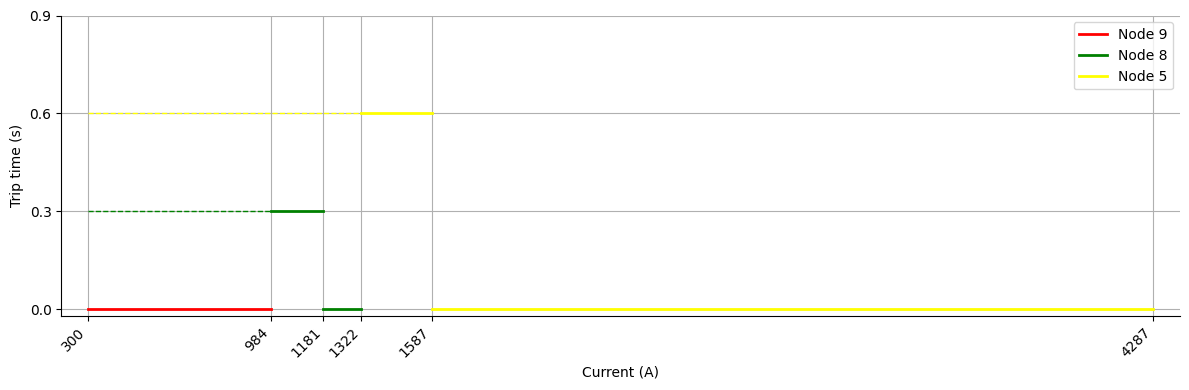

In [35]:
x_values = [I_op] + filtered["max"].tolist() + filtered["multistep"].tolist()
x_values = sorted(set(x_values))
x_values = x_values[:-1]

y_values = [CTI*0, CTI*1, CTI*2, CTI*3]

fig, ax = plt.subplots(figsize=(12,4))
ax.set_xlabel('Current (A)')
ax.set_ylabel('Trip time (s)')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_xticks(x_values)
ax.set_yticks(y_values)
ax.set_xlim(min(x_values)-100, max(x_values)+100)
ax.set_ylim(-0.02, CTI*3)
plt.xticks(rotation=45, ha='right')  # rotate labels to avoid overlap
plt.tight_layout()  # adjust layout to fit labels
plt.grid()


# Node 9 
ax.plot([x_values[0], x_values[1]], [CTI*0, CTI*0], color='red', linewidth=2, label='Node 9')

# Node 8
ax.plot([x_values[0], x_values[1]], [CTI*1, CTI*1], color='green', linewidth=1, linestyle='--')
ax.plot([x_values[1], x_values[2]], [CTI*1, CTI*1], color='green', linewidth=2)
ax.plot([x_values[2], x_values[3]], [CTI*0, CTI*0], color='green', linewidth=2, label='Node 8')

# Node 5
ax.plot([x_values[0], x_values[3]], [CTI*2, CTI*2], color='yellow', linewidth=1, linestyle='--')
ax.plot([x_values[3], x_values[4]], [CTI*2, CTI*2], color='yellow', linewidth=2)
ax.plot([x_values[4], x_values[5]], [CTI*0, CTI*0], color='yellow', linewidth=2, label='Node 5')

ax.legend(loc="upper right")

plt.show()


## Question 5

The previous protection only took into account 3 phase and line to line faults. There is another type of protection that covers single line to ground faults: earth fault protection. In this type of protection, instead of measuring the current in each phase seperately, the current difference between the three phases is measured.

This also gives us an advantage: instead of operating current being limited by the regular current that flows in the line, it is now limited the natural unbalance current, that I'll consider to be ~10A.

The other conditions remain the same:

$$
I_{OP} > 2I_{NU}; I_{OP} < \frac{1}{3}I_{min SC} 
$$

In [31]:
I_NU = 10 # A

filtered_ground = combined_df[combined_df['Node'].isin([5, 8, 9])]
filtered_ground = filtered_ground[["SLG Irms Min[A]", "SLG Irms Max[A]"]]

filtered_ground["min"] = filtered_ground[["SLG Irms Min[A]", "SLG Irms Max[A]"]].min(axis=1)
filtered_ground["max"] = filtered_ground[["SLG Irms Min[A]", "SLG Irms Max[A]"]].max(axis=1)


min_value = filtered_ground["min"].min()
print("Iop > " + str(2*I_NU) + " ; Iop < " + str((1/3)*min_value))

Iop > 20 ; Iop < 189.03333333333333


As we can see above, we no longer have the problem of having to pick between system security and reliability.
Let's pick $I_{OP}$ to be 50A.

In [28]:
I_op_gnd = 50 # A

Aditionally, we will use the normal inverse time function:
$$
t_{op}(I) = \frac{A}{\left(\frac{I}{I_{op}}\right)^p - 1} T_d
$$

Where:  
$p = 0.02$, $A = 0.14$

Here, once again, a problem presents itself - we don't know the value of $T_d$. We can calculate it using the fact that we do know $t_{op}$ at the points where the curves for each node need to be CTI seconds away from eachother, and setting the curve for node 9 at a constant 0 seconds. We then have that:

$t_{op N9} = 0s$ ;  $t_{op ocN8}(I_{sc maxN9}) = CTI = 0.3s$ and finally  $t_{op ocN5}(I_{sc maxN8}) = t_{op ocN8}(I_{sc maxN8}) + CTI$

Solving the equation above for $T_d$:

$$
T_d = \frac{t_{op}}{A}[(\frac{I}{I_{op}})^p-1]
$$

In [29]:
def Td(top, I, Iop, A=0.14, p=0.02):
    return top/A*((I/Iop)**p-1)

def top(Td, I, Iop, A=0.14, p=0.02):
    return A/((I/Iop)**p-1)*Td

Td_n8 = Td(CTI, filtered_ground["max"].iloc[2], I_op_gnd)
top_n8 = top(Td_n8, filtered_ground["max"].iloc[1], I_op_gnd)

Td_n5 = Td(CTI+top_n8, filtered_ground["max"].iloc[1], I_op_gnd)

print(Td_n8)
print(Td_n5)

0.10949346814483499
0.2327108717248442


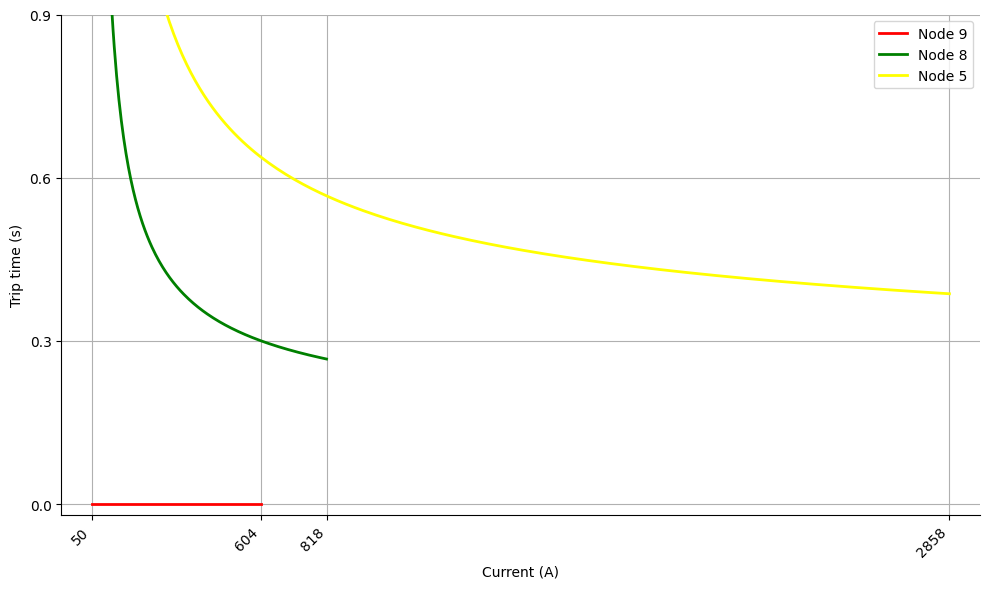

In [36]:
x_values = [I_op_gnd] + filtered_ground["max"].tolist()
x_values = sorted(set(x_values))

y_values = [CTI*0, CTI*1, CTI*2, CTI*3]

fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Current (A)')
ax.set_ylabel('Trip time (s)')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_xticks(x_values)
ax.set_yticks(y_values)
ax.set_xlim(min(x_values)-100, max(x_values)+100)
ax.set_ylim(-0.02, CTI*3)
plt.xticks(rotation=45, ha='right')  # rotate labels to avoid overlap
plt.tight_layout()  # adjust layout to fit labels
plt.grid()

# Node 9 
ax.plot([x_values[0], x_values[1]], [CTI*0, CTI*0], color='red', linewidth=2, label="Node 9")

# Node 8
ax.plot(np.linspace(I_op_gnd*1.0001, x_values[-2], 200), 0.14/((np.linspace(I_op_gnd*1.0001, x_values[-2], 200)/I_op_gnd)**0.02 - 1)*Td_n8, color="green", linewidth=2, label="Node 8")

# Node 5
ax.plot(np.linspace(I_op_gnd*1.0001, x_values[-1], 200), 0.14/((np.linspace(I_op_gnd*1.0001, x_values[-1], 200)/I_op_gnd)**0.02 - 1)*Td_n5, color="yellow", linewidth=2, label="Node 5")

ax.legend(loc="upper right")

plt.show()
